In [2]:
import talos as ta
from talos.metrics.keras_metrics import fmeasure

import pandas as pd
import numpy as np

# this a locally modified version of the actual package
from livelossplot import PlotLossesKeras

from keras.models import Sequential
from keras.layers import Dropout, Dense

# Keras items
from keras.optimizers import Adam, Nadam
from keras.activations import relu, elu, sigmoid
from keras.losses import binary_crossentropy

# 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score

# 
from keras_tqdm import TQDMNotebookCallback

# 
from imblearn.metrics import geometric_mean_score
#########################################################################

%matplotlib inline
pd.set_option("max_columns",90, "max_rows", 90)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys 
sys.path.insert(0, 'C:\\Users\\qzhang\\PycharmProjects\\Mei')
from history.utility import model_fit

from talos.model import lr_normalizer, early_stopper, hidden_layers

def data_prep(raw_df):
    """"""
    df = raw_df.copy()
    
    JUD_ST = ('CT', 'DE', 'FL', 'IL', 'IN', 'KS', 'KY', 'LA', 'ME', 'MA',
              'NE', 'NJ', 'NM', 'NY', 'ND', 'OH', 'OK', 'PA', 'SC', 'SD',
              'VT', 'WI')
    CATE_VAR = ['orig_chn', 'loan_purp', 'prop_type', 'occ_stat', 'judicial_st', 'fhb_flag']

    # drop columns
    df.drop(['loan_id', 'status_prev', 'msa'], axis=1, inplace=True)

    # drop all the observation with missing value
    df.dropna(how='any', inplace=True)

    # create a new feature based on prop_state
    df.loc[:, 'judicial_st'] = df['prop_state'].apply(lambda x: 'Y' if x in JUD_ST else 'N')
    df.drop(['prop_state'], axis=1, inplace=True)

    # convert status to 0 or 1
    df.loc[:, 'status'] = df['status'].apply(lambda x: int(x == 'D60-D90'))

    X = df.drop(['status'], axis=1).copy()
    num_feats = list(set(X.columns) - set(CATE_VAR))
    X = pd.get_dummies(X, columns=CATE_VAR)
    y = df['status'].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

    # mean is computed only over the training data and then subtracted equally from all splits(train/val/test)
    scaler = StandardScaler()
    X_train.loc[:, num_feats] = scaler.fit(X_train[num_feats]).transform(X_train[num_feats])
    X_test.loc[:, num_feats] -= scaler.mean_
    X_test.loc[:, num_feats] /= scaler.scale_
    return X_train, X_test, y_train, y_test

# read data
raw_df = pd.read_csv('..\Data\Gse_panel_current_sample_raw.csv')


C:\Users\qzhang\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
def neural_nets(X_train, y_train, X_val, y_val, params):
    model = Sequential()
    model.add(Dense(params['first_neuron'], 
                    input_dim=X_train.shape[1],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.add(Dropout(params['dropout']))

    hidden_layers(model, params, 1)

    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer=params['kernel_initializer']))
    
    model.compile(loss=params['losses'],
                  optimizer=params['optimizer'](),
                  metrics=['acc'])
    
    history = model.fit(X_train, y_train, 
                        validation_data=[X_val, y_val],
                        batch_size=params['batch_size'],
                        callbacks=[],  # , TQDMNotebookCallback() PlotLossesKeras()
                        epochs=params['epochs'],
                        verbose=0)

    # predict 
    prob_pos = model.predict(X_val, batch_size=params['batch_size'], verbose=0) 
    vfunc = np.vectorize(lambda x: 1 if x > 0.05 else 0)
    y_pred = vfunc(prob_pos)

    # calculate metrics
    precision, recall, _ = precision_recall_curve(y_val, prob_pos) 
    fpr, tpr, _ = roc_curve(y_val, prob_pos)
    roc_auc = auc(fpr, tpr)
    pr_auc = average_precision_score(y_val, prob_pos)
    exp_pos = np.sum(prob_pos)
    f_score = f1_score(y_val, y_pred)
    g_mean = geometric_mean_score(y_val, y_pred)

    op = {'PR_AUC': pr_auc,
          'ROC_AUC': roc_auc,
          'F score': f_score,
          'G mean': g_mean,
          'Expeted num of D60-D90': exp_pos,
          'Actual num of D60-D90': np.sum(y_val),}
    print(model.summary())
    return history, model, op

In [7]:
# split sample set
X, X_test, y, y_test = data_prep(raw_df)


In [8]:
# p = {'lr': [10**i for i in range(-6, 1)],
#      'first_neuron': (4, 46, 4),
#      # 'hidden_layers': [0, 1, 2, 3],
#      'batch_size': [2**i for i in range(2, 13)],
#      'epochs': (5, 100, 5),
#      'dropout': (0, 0.5, 5),
#      'kernel_initializer': ['uniform','normal'],
#      'optimizer': [Nadam, Adam],
#      'losses': [binary_crossentropy],
#      'activation': [relu],
#      'last_activation': [sigmoid]}

p = {'lr': [2, 1],
     'first_neuron': [5],
     'hidden_layers': [1],
     'batch_size': [2000],
     'shapes': ['funnel'],
     'epochs': [1],
     'dropout': [0],
     'kernel_initializer': ['uniform'],
     'optimizer': [Adam],
     'losses': [binary_crossentropy],
     'activation': [relu],
     'last_activation': [sigmoid]}


In [ ]:
t = ta.Scan(x=X.values,
            y=y.values,
            val_split=.2,
            model=neural_nets,
            grid_downsample=None, 
            params=p,
            search_method='random',
            dataset_name='Mei_NN_HPT',
            experiment_no='50',
            debug = False)  # 

In [3]:
df = raw_df.copy()

JUD_ST = ('CT', 'DE', 'FL', 'IL', 'IN', 'KS', 'KY', 'LA', 'ME', 'MA',
          'NE', 'NJ', 'NM', 'NY', 'ND', 'OH', 'OK', 'PA', 'SC', 'SD',
          'VT', 'WI')
CATE_VAR = ['orig_chn', 'loan_purp', 'prop_type', 'occ_stat', 'judicial_st', 'fhb_flag']

# drop columns
df.drop(['loan_id', 'status_prev', 'msa'], axis=1, inplace=True)

# drop all the observation with missing value
df.dropna(how='any', inplace=True)

# create a new feature based on prop_state
df.loc[:, 'judicial_st'] = df['prop_state'].apply(lambda x: 'Y' if x in JUD_ST else 'N')
df.drop(['prop_state'], axis=1, inplace=True)

# convert status to 0 or 1
df.loc[:, 'status'] = df['status'].apply(lambda x: int(x == 'D60-D90'))

X = df.drop(['status'], axis=1).copy()
num_feats = list(set(X.columns) - set(CATE_VAR))
X = pd.get_dummies(X, columns=CATE_VAR)
y = df['status'].copy()

In [7]:
X = X[['orig_rt', 'orig_upb', 'oltv', 'num_bo', 'dti', 'num_unit', 'fico',
       'oyr', 'oqtr', 'ind_ede', 'pmms_o', 'avg_upb', 'OUPB_Rel',
       'loan_age_qtr', 'year', 'qtr', 'PMMS', 'HPI_O', 'HPI', 'ur',
       'CUPB_calc', 'Orig_value', 'CLTV']]
X.mean()

orig_rt              5.611685
orig_upb        187982.167608
oltv                71.936251
num_bo               1.540641
dti                 33.975237
num_unit             1.034372
fico               758.571401
oyr               2006.974894
oqtr                 2.498620
ind_ede              0.008725
pmms_o               5.575516
avg_upb         198473.210078
OUPB_Rel             0.943726
loan_age_qtr        10.608284
year              2009.544007
qtr                  2.494559
PMMS                 4.967756
HPI_O              201.141712
HPI                203.240516
ur                   7.002412
CUPB_calc       181973.867987
Orig_value      280272.894565
CLTV                68.568598
dtype: float64

In [15]:
a = []
for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
    a.append(pd.DataFrame(X_train.mean()).T)

df = pd.concat(a)

In [9]:
type(X.mean())

pandas.core.series.Series

In [16]:
df

,orig_rt,orig_upb,oltv,num_bo,dti,num_unit,fico,oyr,oqtr,ind_ede,pmms_o,avg_upb,OUPB_Rel,loan_age_qtr,year,qtr,PMMS,HPI_O,HPI,ur,CUPB_calc,Orig_value,CLTV
0,5.611517,187981.669588,71.925080,1.541258,33.976267,1.034426,758.564414,2006.975237,2.498659,0.008726,5.575265,198458.498358,0.943856,10.604176,2009.543315,2.494370,4.968328,201.157978,203.251394,7.002697,181973.855201,280336.441386,68.561137
0,5.611126,188021.174226,71.941424,1.540576,33.964632,1.034213,758.579906,2006.976037,2.497641,0.008725,5.575109,198460.246434,0.944055,10.609584,2009.545212,2.494712,4.967421,201.158328,203.253590,7.004179,182010.357035,280228.714986,68.579025
0,5.611605,187993.842361,71.939497,1.540928,33.966597,1.034372,758.571140,2006.973293,2.498496,0.008722,5.575695,198484.607749,0.943756,10.618841,2009.545260,2.493555,4.967330,201.108790,203.230592,7.003114,181979.349950,280185.511778,68.563461
0,5.610598,188014.009065,71.936249,1.540617,33.971514,1.034462,758.557784,2006.978468,2.499127,0.008726,5.574675,198477.936623,0.943897,10.600006,2009.545986,2.493011,4.967367,201.161299,203.264388,7.000933,182011.371188,280302.419947,68.567906
0,5.611159,188020.670465,71.936994,1.540662,33.973418,1.034345,758.537580,2006.976554,2.499361,0.008725,5.574911,198506.413512,0.943726,10.607689,2009.545822,2.493874,4.967331,201.157981,203.259082,7.002208,182012.621210,280337.252606,68.570614
0,5.611357,187983.482128,71.925270,1.540630,33.971752,1.034438,758.559074,2006.975666,2.497272,0.008725,5.575361,198510.218215,0.943719,10.604675,2009.543482,2.494760,4.967982,201.174261,203.250605,7.002842,181974.845520,280354.551528,68.565620
0,5.611573,188016.700376,71.933659,1.540495,33.975087,1.034272,758.595158,2006.976396,2.497804,0.008726,5.575588,198516.709731,0.943703,10.608579,2009.545336,2.494927,4.967325,201.169721,203.251083,7.002329,182005.365713,280286.965149,68.570256
0,5.611579,187975.204442,71.929811,1.540887,33.976344,1.034541,758.576372,2006.974461,2.499389,0.008724,5.575264,198457.254716,0.943747,10.608091,2009.543872,2.494120,4.967970,201.167662,203.244127,7.001498,181967.247577,280258.709709,68.572951
0,5.611108,187971.300604,71.929803,1.540312,33.979032,1.034281,758.578336,2006.978165,2.498146,0.008725,5.574878,198507.598063,0.943467,10.600575,2009.545201,2.494249,4.967867,201.152237,203.256362,7.001124,181970.467364,280243.980614,68.561655
0,5.611086,188023.223023,71.948505,1.540908,33.976244,1.034355,758.560701,2006.978053,2.497972,0.008724,5.574575,198528.232479,0.943686,10.603727,2009.546190,2.493430,4.967477,201.163326,203.253644,7.004266,182016.366900,280247.094081,68.580262


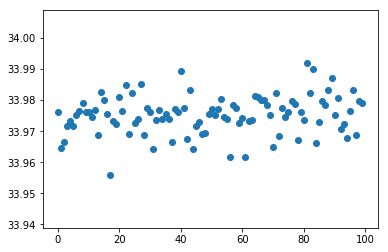

In [29]:
import matplotlib.pyplot as plt
plt.scatter(range(df['dti'].shape[0]), df['dti'])

In [30]:
df.mean()

orig_rt              5.611529
orig_upb        187993.839574
oltv                71.934238
num_bo               1.540647
dti                 33.975258
num_unit             1.034373
fico               758.572091
oyr               2006.975274
oqtr                 2.498554
ind_ede              0.008725
pmms_o               5.575388
avg_upb         198480.893398
OUPB_Rel             0.943751
loan_age_qtr        10.607224
year              2009.544106
qtr                  2.494537
PMMS                 4.967723
HPI_O              201.142186
HPI                203.241356
ur                   7.002546
CUPB_calc       181985.890538
Orig_value      280296.033981
CLTV                68.567482
dtype: float64

In [34]:
X.mean()['oltv']

71.93625059751315

In [31]:
df.std()

orig_rt           0.000553
orig_upb         55.693518
oltv              0.008464
num_bo            0.000278
dti               0.006231
num_unit          0.000117
fico              0.021608
oyr               0.001841
oqtr              0.000525
ind_ede           0.000003
pmms_o            0.000522
avg_upb          30.327957
OUPB_Rel          0.000219
loan_age_qtr      0.004884
year              0.001564
qtr               0.000618
PMMS              0.000439
HPI_O             0.021781
HPI               0.022305
ur                0.001237
CUPB_calc        54.770351
Orig_value      110.740140
CLTV              0.009624
dtype: float64

In [36]:
e = df['oltv'] - X.mean()['oltv']

In [37]:
e.mean()

-0.002012927165568499

In [38]:
e.std()

0.00846448469484428

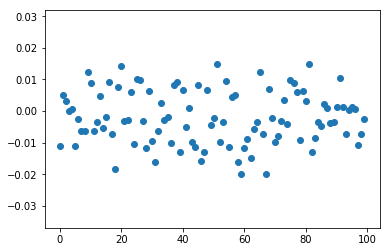

In [47]:
plt.scatter(range(len(e)), e.values)